### Prediction of Diabeties - Tanmay Gupta

### Introduction

The purpose of this project is to develop a logistic regression problem from scratch, to understand how the concepts learnt in class can be applied to real life Data Science projects. To understand the basics of this, a good understanding of mathematical statistics is recommended. 

The problem statement is to predict whether a patient has diabetes or not $(y_i)$, based on the data that we have on the patient. This data is held on UCI Repository and is available for public use with no Copyright. The initial dataframe $\mathbf{X}$ consists of 768 patients and we have 9 features for them. 

* Pregnancies
* Glucose
* Blood Pressure
* Skin Thickness
* Insulin
* BMI
* Diabetes Pedigree Function
* Age
* Outcome (whether diabetic or not)

Our job is to build a model that will predict $y_i$ based on the data for each person, $x_i \in \mathbf{X}$

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading dataset
data = pd.read_csv("Data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Missing Values**

Missing values in data can really affect the performance of the model if the amount is sufficiently high. Here, we can notice that a few values in the *Insulin* and *Skin Thickness* columns have a value of 0, which isn't biologically possible. So that would really mean that we have no value for them. I will be converting them to NA and then dealing with them appropriately later. 

Notice that the same hasn't been done for Pregnancies since a person can have 0 pregnancies. Any missing data in this case would go un-noticed.

In [3]:
for i in range(1,6):
    data.iloc[:,i][data.iloc[:,i] == 0] = None

In [4]:
# Utility Functions

def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100*(start_mem - end_mem)/start_mem))
    return df

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending = False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
def column_plot(dataframe, value):
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize = (14,6), dpi = 80)
    sns.boxplot(x = 'Outcome', y = value, data = dataframe, ax = axes[0])
    sns.scatterplot(x = value, y = 'Outcome', data = dataframe)

    # Set Title
    axes[0].set_title('Box Plot', fontsize = 18); 
    axes[1].set_title('Plot', fontsize = 18)
    plt.show()

In [5]:
# Reducing data requirements
data = reduce_mem_usage(data)

Mem. usage decreased to  0.01 Mb (79.1% reduction)


### Exploratory Data Analysis

#### Macro trends in the data

In [6]:
# Finding missing values 
missing_values = missing_values_table(data)
missing_values.style.background_gradient(cmap = 'Oranges')

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Insulin,374,48.7
SkinThickness,227,29.6
BloodPressure,35,4.6
BMI,11,1.4
Glucose,5,0.7


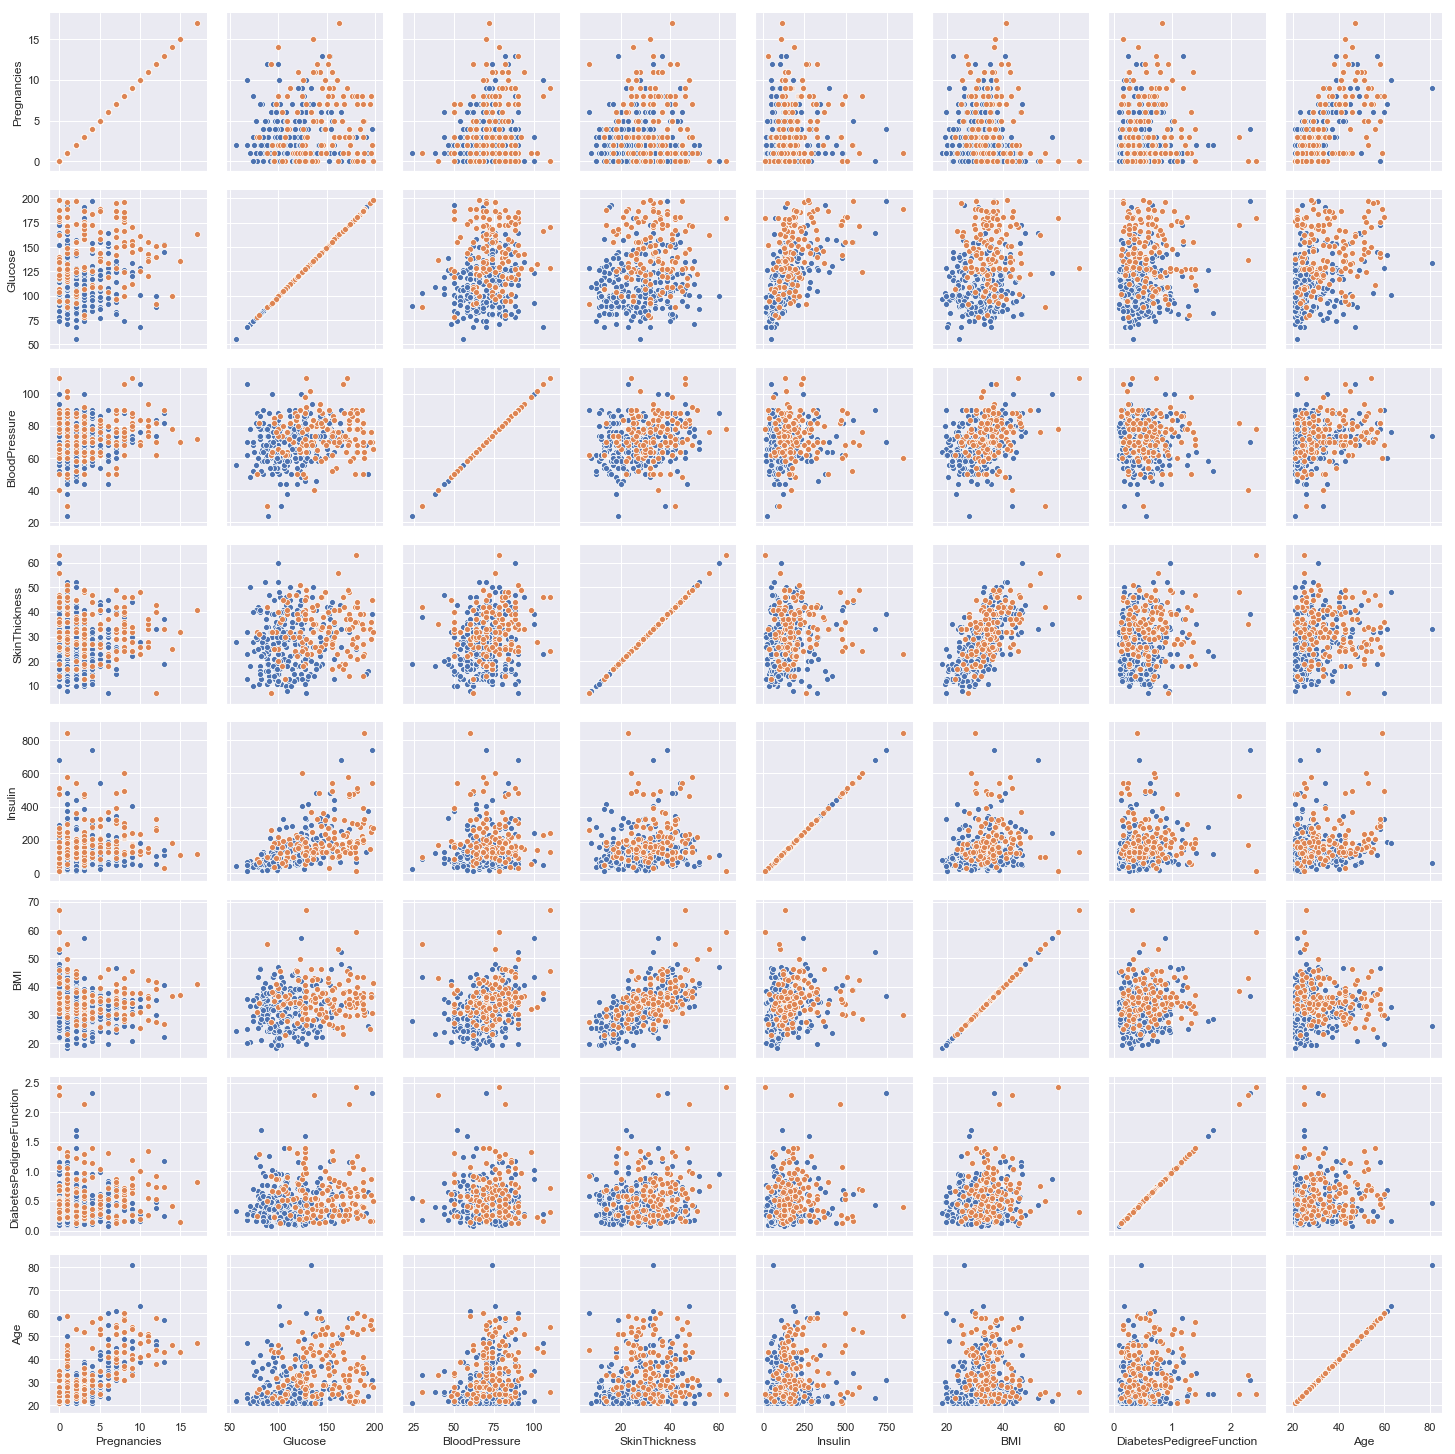

In [7]:
g = sns.PairGrid(data.dropna(), hue = 'Outcome')
g = g.map(sns.scatterplot)

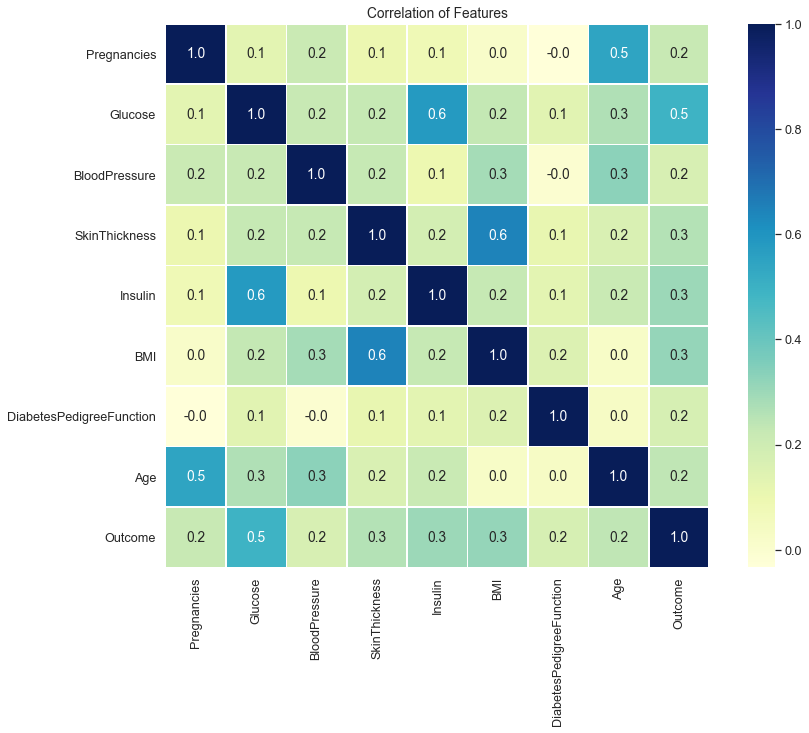

In [8]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (14, 10))
sns.heatmap(data.corr(), vmax = 1, linewidths = 0.5, fmt = '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('Correlation of Features');

#### Analysis of features with Target

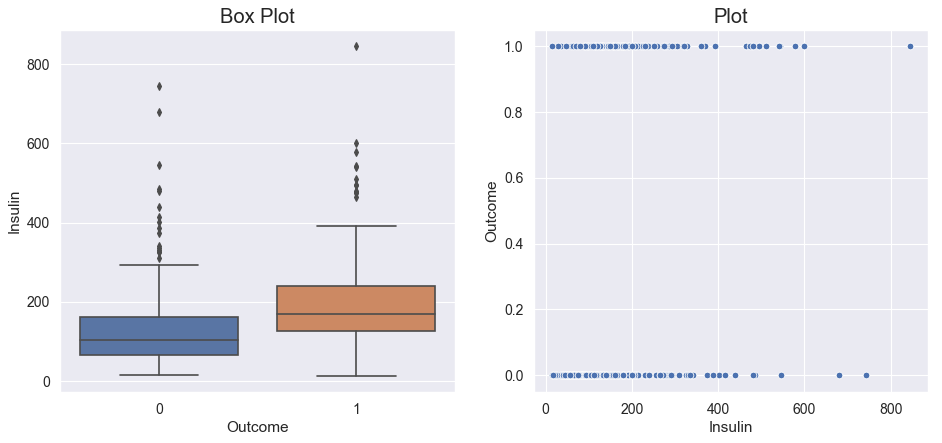

In [9]:
column_plot(data, 'Insulin')

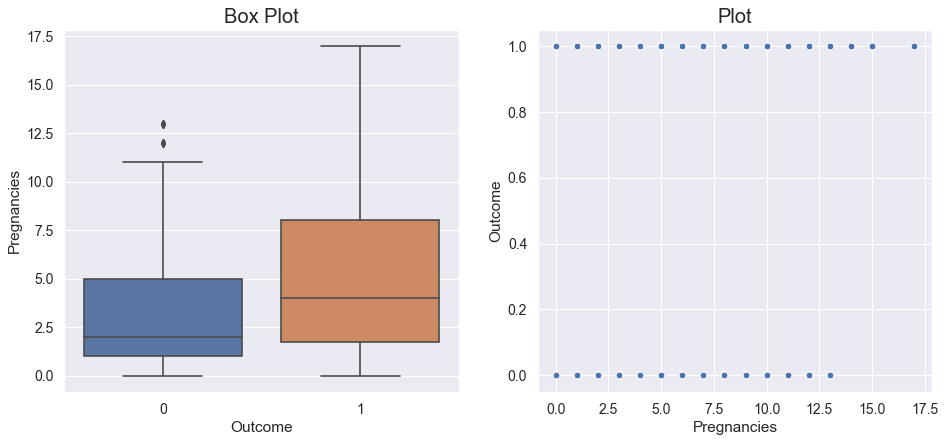

In [10]:
column_plot(data, 'Pregnancies')

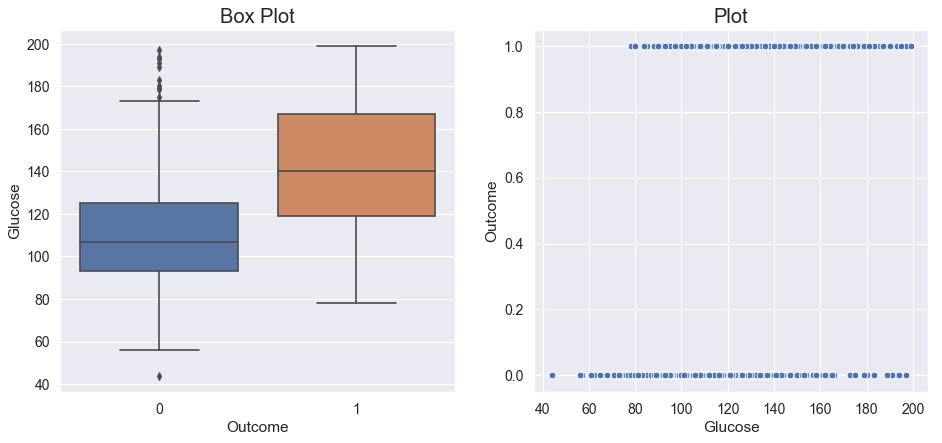

In [11]:
column_plot(data, 'Glucose')

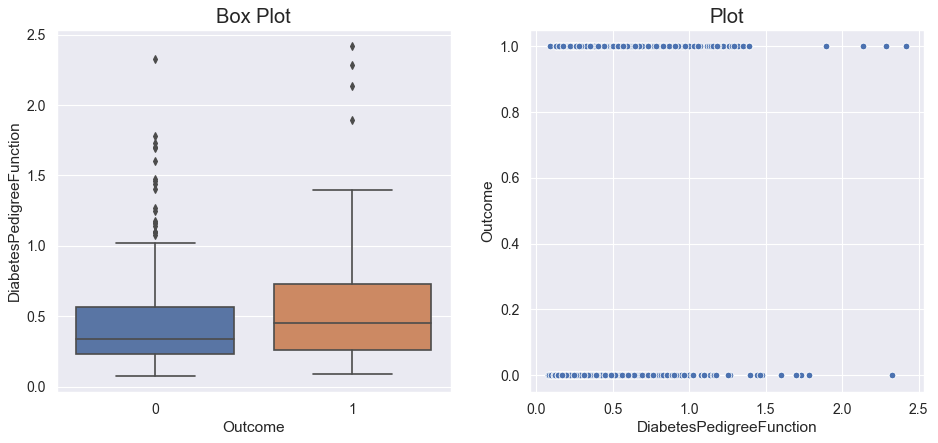

In [12]:
column_plot(data, 'DiabetesPedigreeFunction')

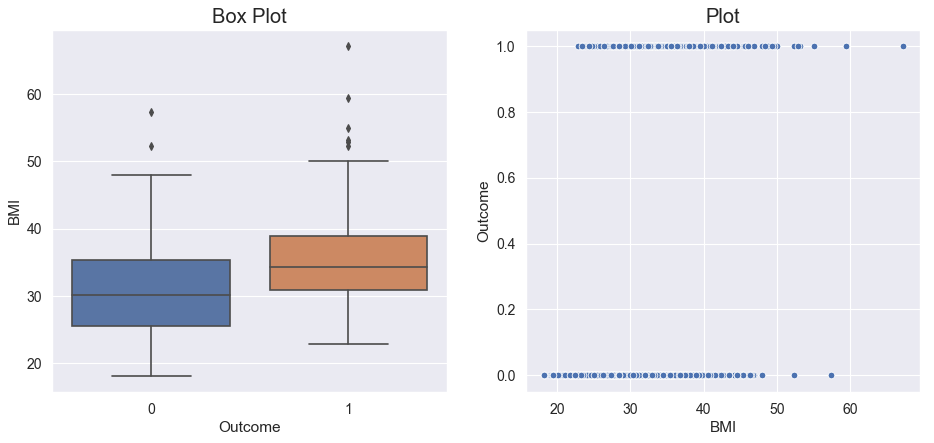

In [13]:
column_plot(data, 'BMI')

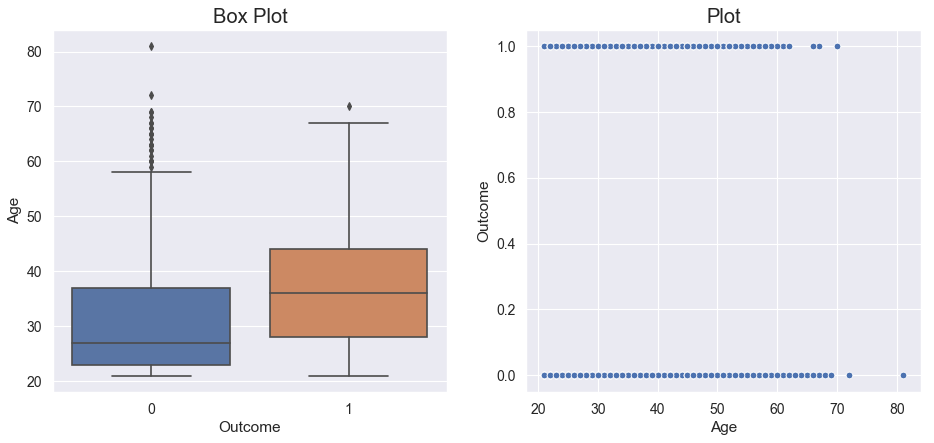

In [14]:
column_plot(data, 'Age')

### Modeling

To predict Diabetes in a person, given this data, we will create a **Logistic Regression model**. Logistic Regression is a standard statistical technique used in Classification tasks. The fundamental assumption here is that the Target Variable is a categorical variable (from a binomial or multinomial distribution) dependent on the dataset $\mathbf{X}$. In our example here, for the probability a subject has Diabetes given data $x_i \in \mathbf{X}$ follows the following general model:

\begin{equation*}
P(y = 1 | \mathbf{X}, \theta )   = \frac{1}{1+ e^{-\theta^T \mathbf{X}}}
\end{equation*}

So given our variables that we analyzed above, we will develop the model by numerically optimizing the coefficients to yield the maximum Likelihood estimates for the coefficients. We will be approaching that in the following few sections. But before that, we need to make sure our data is ready for the *training* of the model.  

In [15]:
# Removing NA values
rows_pre = data.shape[0]
data = data.dropna()
rows_post = data.shape[0]
y = data["Outcome"].values # Creating y-vector for training
x = data.drop(["Outcome"], axis=1) # Removing  target values from x dataframe
print("Removed {a} values from the dataset, leaving {b} rows with complete data".format(a = rows_pre - rows_post, b = rows_post))

Removed 376 values from the dataset, leaving 392 rows with complete data


Since the model is fed data to begin with, it is essential that our data is reliable and sufficient for our numerical methods to converge to a solution. Having missing data in our dataframe cannot be processed by most statistical methods, and those which do either impute arbitrary values or just remove the datapoints that are missing (depending on the situation). 

In our model, I will be removing the missing data. We can see that doing that procedure leaves us with 392 rows of data. A good rule of thumb for Logistic Regression is the **Rule of 10**, which states that we should have atleast **10 datapoints for every predictive feature** in the model. 

Given that our model has 8 features, we  have on average just under **50 observations per predictive feature** for our model. Thus, by removing that missing data, we aren't putting our model at a risk of underfitting (having sub-optimal coefficients because the loss function did not converge).  

In [16]:
# Normalizing data as a general rule while doing regression
x = (x - np.min(x))/(np.max(x) - np.min(x)).values

Normalizing data is generally considered a good practice. H

aving standardized the data, we will now split the data into **Train** and **Test** categories. The **Train** set is the data that will be fed to the model to find optimal coefficients and **Test** set is the data that we will evaluate the performance of our model on. So essentially, **Train** is the dataset that the model sees and learns from while **Test** is what we test the model against. 

In this case, we will randomly allocate 20% of the data to test and train on the remaining 80% of the data. Note that even after this split, we have sufficient observations per feature to get a reliable estimate. 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 172)

x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (8, 313)
x_test:  (8, 79)
y_train:  (313,)
y_test:  (79,)


Here is where we define the functions that build up our model from scratch. We define the following functions here:

**Sigmoid function:** This is the function that I introducted earlier, to get $P(y=1|\mathbf{X},\theta)$. This is defined as $$P(y=1|\mathbf{X},\theta) = \sigma(\theta^T \cdot x_i) = \frac{1}{1+e^{-\theta^T \cdot x_i}}$$


**Forward and Backward Propagation:** This is the function that updates the parameters $\theta$ in each iteration. It returns the gradients to calculate new parameter values by taking a step in the direction that maximizes the Log Likelihood function from that point (the gradient itself). This method is called Gradient Descent. We use this method because it's hard to find closed form solutions for Logistic Regression problems like we can for Linear Regression. 


* The function that we are **maximizing is the Log Likelihood function** (or conversely minimizing the negative Log Likelihood). The function is given as: $$\mathcal{L}(\mathbf{X}|\theta) = -\log p(y | z) = -y \log \sigma(z) - (1-y)\log \sigma(-z)$$ where $z = \theta^T \cdot \mathbf{X}$. The negative log Likelihood function is convex and differentiable so we can find a minimum. 


* To maximize any function, we need the **Gradient information** for that function, with respect to the parameters. For the log Likelihood function, the following is the gradient function: $$\nabla \mathcal{L}(\mathbf{X}|\theta) = \frac{1}{n} \left ( \mathbf{X}^T \cdot \left ( \sigma (z) - y \right )^T \right )$$ where n is the number of observations we have.

**Optimization:** The next function is defined to take in a set of initial weights $(\theta)$, the dataset $(\mathbf{X})$, the target variable $(y)$, and a learning rate $(\alpha)$ and returns optimized values by runnning the *forward_backward_propagation* function until the parameters converge. It does this by using the following iteration function: $$\theta_{i+1} = \theta_{i} - \alpha \times \nabla \mathcal{L}(\mathbf{X}|\theta_i)$$

**Prediction:** Once we have the optimized parameters $(\theta_*)$ then we need to find $z = \theta_*^{T} \cdot \mathbf{X}$. Now that we have the predicted probabilities, we will now use a simple rule to classify the datapoint as either 1 (Diabetic) or 0 (Not Diabetic). In our case, we will keep the threshold at 0.5. So then our function looks like:

$$\hat{y} = \begin{cases} 
      1 & z> 0.5 \\
      0 & z\leq 0.5 
   \end{cases}$$



In [18]:
def initialize_weight_and_bias(dimension):
     w = np.full((dimension,1), 0.0)
     b = 0.0
     return w, b

def sigmoid(z):
    y_hat = 1/(1 + np.exp(-z))
    return y_hat

def forward_backward_propagation(w, b, x_train, y_train):
    #forward propagation
    z = np.dot(w.T, x_train) + b
    y_hat = sigmoid(z)
    loss = -y_train*np.log(y_hat) - (1 - y_train)*np.log(1 - y_hat)
    cost = (np.sum(loss))/x_train.shape[1] 
    
    # backward propagation
    derivative_weight = (np.dot(x_train, ((y_hat - y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_hat - y_train)/x_train.shape[1] # x_train.shape[1]  is for scaling. It is giving sample count
    gradients = {"d_weights": derivative_weight, "d_bias": derivative_bias}
    
    return cost, gradients

def optimize_params(w, b, x_train, y_train, learning_rate, number_of_iteration):
    cost_list_all = []
    cost_list_print = []
    index = []
    
    # updating(learning) parameters is number_of_iteration times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost, gradients = forward_backward_propagation(w, b, x_train, y_train)
        cost_list_all.append(cost)
        # lets update
        w = w - learning_rate*gradients["d_weights"]
        b = b - learning_rate*gradients["d_bias"]
        if i % 20 == 0: #show slopes for range of 10%
            cost_list_print.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
            
    # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(index, cost_list_print)
    plt.xticks(index, rotation = 'vertical')
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list_all

def predict(w, b, x):
    
    z = sigmoid(np.dot(w.T, x) + b)
    Y_prediction = np.zeros((1, x.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i] <= 0.5: # If higher than 0.5, will consider it a positive case
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations):
    # initialize
    dimension =  x_train.shape[0]
    w, b = initialize_weight_and_bias(dimension)
    
    parameters, gradients, cost_list = optimize_params(w, b, x_train, y_train, learning_rate, num_iterations)
    
    y_prediction_test = predict(parameters["weight"], parameters["bias"], x_test)

    print("Test Accuracy: {}%".format(round(100 - np.mean(np.abs(y_prediction_test - y_test))*100,2)))
    
    return y_prediction_test

### Running the model

Now that the basic steps have been covered, we will run the model on the data and determine what the overall accuracy looks like. 

Cost after iteration 0: 0.693147
Cost after iteration 20: 0.559800
Cost after iteration 40: 0.519389
Cost after iteration 60: 0.500033
Cost after iteration 80: 0.489552
Cost after iteration 100: 0.483334
Cost after iteration 120: 0.479379
Cost after iteration 140: 0.476723
Cost after iteration 160: 0.474856
Cost after iteration 180: 0.473495
Cost after iteration 200: 0.472470
Cost after iteration 220: 0.471677
Cost after iteration 240: 0.471048
Cost after iteration 260: 0.470540
Cost after iteration 280: 0.470123
Cost after iteration 300: 0.469775
Cost after iteration 320: 0.469482
Cost after iteration 340: 0.469232
Cost after iteration 360: 0.469018
Cost after iteration 380: 0.468833


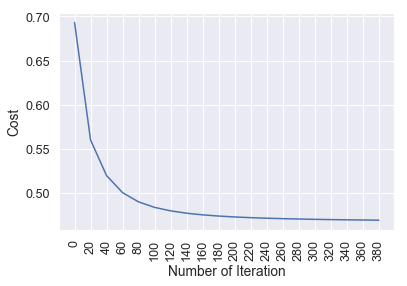

Test Accuracy: 84.81%


In [19]:
y_test_pred = logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 2, num_iterations = 400)  

We see 3 main components here, the first is a set of evenly spaced cost iterates, the second is a plot of those iterates w.r.t. the iterations, and lastly we have the accuracy when evaluated against the Test dataset. Just to re-emphasize, the model has not seen this data yet. So these are all blind predictions the model is making based on what it has been trained on.

**Loss function:** We can see that the loss function levels off after 380 iterations. The loss function saw a dramatic decrease which is good, which would translate to us maximizing the Log Likelihood function. As we can no longer make any improvement (looking at the meagre slope towards the end), instead of wasting more time training the model, we evaluate the performance to check whether the model is performing well at this level or not. 

**Accuracy:** Once we have the model, the next step is to check the accuracy of the results we get from it. Here, we are finding the average number of correct predictions made. Looking at that, we get an accuracy of $84.81$% which seems like the model is performing fairly well. But this is not the only metric that statisticians use to evaluate this model's performance. As we will see below, there are a few other metrics that people have used and resources for which can easily be found online!

In [20]:
y_test_pred = y_test_pred.astype(np.int64)[0]
print(confusion_matrix(y_test, y_test_pred))
print('Precision Score {}'.format(round(precision_score(y_test,y_test_pred),3)))
print('Recall Score {}'.format(round(recall_score(y_test,y_test_pred),3)))
print("ROC AUC {}".format(round(roc_auc_score(y_test,y_test_pred),3)))

[[51  3]
 [ 9 16]]
Precision Score 0.842
Recall Score 0.64
ROC AUC 0.792


For the purpose of the project, the concepts covered in class are Logistic Regression and Likelihood function while the new concept that I will be covering briefly is Gradient Descent.

Thank you for a wonderful class and experience, despite all the challenges we faced. It's been a pleasure.

Regards and Good luck. 